In [ ]:
!pip install --upgrade scikit-learn lightgbm gensim transformers tensorflow tensorflow-hub tabulate iterative-stratification

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 22.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.0 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
  Attempting uninstall: lightgbm
    Found existing installation: lightgbm 4.1.0
    Uninstalling lightgbm-4.1.0:
      Successfully uninstalled lightgbm-4.1.0
  Attempting uninstall: transformers
    Found existing installation: transformers 4.35.2
    Uninstalling transformers-4.35.2:
      Successfully uninstalled transformers-4.35.2
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.15.0
    Uninstalling tensorflow-2.15.0:
      Successfully uninstalled tensorflow-

# 0. Libraries & packages

In [ ]:
# Standard Libraries
import os
import re
from collections import Counter

# Data Manipulation Libraries
import numpy as np
import pandas as pd

# Visualization Libraries
import matplotlib.pyplot as plt

# NLP Libraries
import nltk
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import MWETokenizer
import gensim
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument, Doc2Vec
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS

# Machine Learning Libraries
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn import utils
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

# Deep Learning Libraries
import tensorflow as tf
import tensorflow_hub as hub
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification

# Additional Libraries
import joblib
from bs4 import BeautifulSoup
import pickle

# Disable all warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# 1. Download data and Cleaning the tags

In [ ]:
# Load data
data = pd.read_csv('/content/drive/MyDrive/Datasets/50k_posts.csv')
data = data [['Title', 'Body','Tags']]
data

,Title,Body,Tags
0,"How do I get a distinct, ordered list of names...",<p>I have a <code>DataTable</code> with a <cod...,<c#><linq><.net-3.5>
1,"Microsoft Office 2007 file type, Mime types an...",<p>Where can I find a list of all of the MIME ...,<mime><file-type><office-2007>
2,Paging a collection with LINQ,<p>How do you page through a collection in LIN...,<linq><.net-3.5>
3,Getting Subclipse in Aptana to work with the n...,<p>The version of <strong>Subclipse (1.2.4)</s...,<eclipse><svn><aptana><subclipse>
4,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...,<apache-flex><actionscript-3><air>
...,...,...,...
51993,"Difference between const std::array<T,N> and s...",<p>Is there any practical difference between <...,<c++>
51994,What does assignment to a bracketed expression...,<p>I'm reading Avalonia source code and I came...,<c#><collection-initializer>
51995,What should the result be when assigning a var...,<pre><code>#include &lt;iostream&gt;\n\nint&am...,<c++><sequence-points>
51996,File pattern '*.apk' (from 'bundled' plugin) w...,<p>Suddenly android studio showed this message...,<android><android-studio><apk><bundle><archive>


In [ ]:
# Function to clean tags
"""
1. Initial Tags Format: The original tags are in the format <tag1><tag2>....

2. Splitting Tags: The tags are split into a list by removing the angle brackets and splitting on '><'. This results in a list of tags.

3. First Word Before Hyphen: For each tag, we keep only the first word before the first hyphen (if any). This is done to simplify tags containing hyphens.

4. Special Cases Handling: Certain tags are considered special cases. If a tag starts with specific words like 'angular', 'c++', etc., or is 'java' (excluding 'javascript'), we keep only that word.

5. Removing Duplicates: After cleaning, duplicates within each row are removed to ensure unique tags in each row.

"""

def clean(tags):
    cleaned_tags = []
    seen_tags = set()

    for tag in tags.strip('<>').split('><'):
        # Keep only the first word before the first hyphen
        index_of_hyphen = tag.find('-')
        if index_of_hyphen != -1:
            tag = tag[:index_of_hyphen]

        # Check for special start words
        special_start_words = [
            'angular', 'apache', 'c++', 'http', 'interrupt', 'ios', 'python', 'iterat',
            'json', 'mysql', 'scala', 'oracle', 'ruby', 'sql', 'sublime', 'swift',
            'symfony', 'system', 'tcp', 'template', 'text', 'time', 'tomcat', 'typescript',
            'ui', 'vue', 'web', 'xcode'
        ]

        for start_word in special_start_words:
            if tag.lower().startswith(start_word):
                # Special case for 'java' (ignoring 'javascript')
                if start_word == 'java' and not tag.lower().startswith('javascript'):
                    cleaned_tags.append(start_word)
                else:
                    cleaned_tags.append(start_word)
                seen_tags.add(start_word)
                break
        else:
            if tag not in seen_tags:
                cleaned_tags.append(tag)
                seen_tags.add(tag)

    return cleaned_tags

def remove_duplicates(tag_list):
    return list(set(tag_list))

In [ ]:
# Apply the function to the 'Tags' column
data['Tags_cleaned'] = data['Tags'].apply(clean)
# Apply the function to the 'Tags_cleaned' column
data['Tags_cleaned'] = data['Tags_cleaned'].apply(remove_duplicates)

In [ ]:
data

,Title,Body,Tags,Tags_cleaned
0,"How do I get a distinct, ordered list of names...",<p>I have a <code>DataTable</code> with a <cod...,<c#><linq><.net-3.5>,"[.net, linq, c#]"
1,"Microsoft Office 2007 file type, Mime types an...",<p>Where can I find a list of all of the MIME ...,<mime><file-type><office-2007>,"[mime, file, office]"
2,Paging a collection with LINQ,<p>How do you page through a collection in LIN...,<linq><.net-3.5>,"[.net, linq]"
3,Getting Subclipse in Aptana to work with the n...,<p>The version of <strong>Subclipse (1.2.4)</s...,<eclipse><svn><aptana><subclipse>,"[eclipse, subclipse, svn, aptana]"
4,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...,<apache-flex><actionscript-3><air>,"[air, apache, actionscript]"
...,...,...,...,...
51993,"Difference between const std::array<T,N> and s...",<p>Is there any practical difference between <...,<c++>,[c++]
51994,What does assignment to a bracketed expression...,<p>I'm reading Avalonia source code and I came...,<c#><collection-initializer>,"[collection, c#]"
51995,What should the result be when assigning a var...,<pre><code>#include &lt;iostream&gt;\n\nint&am...,<c++><sequence-points>,"[c++, sequence]"
51996,File pattern '*.apk' (from 'bundled' plugin) w...,<p>Suddenly android studio showed this message...,<android><android-studio><apk><bundle><archive>,"[android, bundle, apk, archive]"


In [ ]:
def find_tags_by_threshold(data, threshold):
    # Assuming data['Tags'] contains the cleaned tags
    all_tags = [tag for tags_list in data['Tags_cleaned'] for tag in tags_list]
    # Count occurrences of each tag
    tag_counts = pd.Series(all_tags).value_counts().reset_index()
    tag_counts.columns = ['Tag', 'Count']
    # Compute the cumulative distribution
    tag_counts['Cumulative_Distribution'] = tag_counts['Count'].cumsum() / tag_counts['Count'].sum()
    # Find the tags representing the specified cumulative distribution threshold
    tags_threshold = tag_counts[tag_counts['Cumulative_Distribution'] <= threshold]
    return tags_threshold

# Example usage with a threshold of 0.5
threshold = 0.65

tags_threshold = find_tags_by_threshold(data, threshold)
# Display the resulting DataFrame
tags_threshold

,Tag,Count,Cumulative_Distribution
0,c#,5887,0.040481
1,java,4771,0.073287
2,python,4422,0.103694
3,javascript,3815,0.129927
4,.net,3106,0.151284
...,...,...,...
195,encryption,108,0.647056
196,vector,107,0.647791
197,search,106,0.648520
198,flutter,105,0.649242


In [ ]:
# Assuming list_tags is the list of cleaned and filtered tags
list_tags = tags_threshold['Tag'].tolist()

# Apply transformation to keep only tags that are in list_tags
data['Filtered_Tags'] = data['Tags_cleaned'].apply(lambda tags: [tag for tag in tags if tag in list_tags])

# Remove rows with empty filtered tags
data = data[data['Filtered_Tags'].apply(len) > 0].reset_index(drop=True)

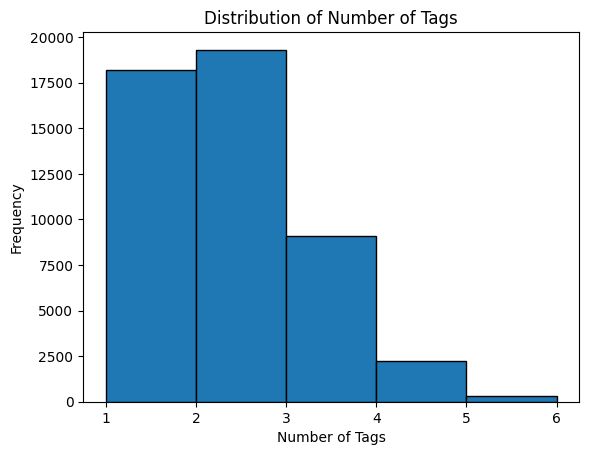

In [ ]:
# Plot a histogram of the number of tags
plt.hist(data['Filtered_Tags'].apply(len), bins=range(1, max(data['Filtered_Tags'].apply(len)) + 2), edgecolor='black')
plt.xlabel('Number of Tags')
plt.ylabel('Frequency')
plt.title('Distribution of Number of Tags')
plt.show()

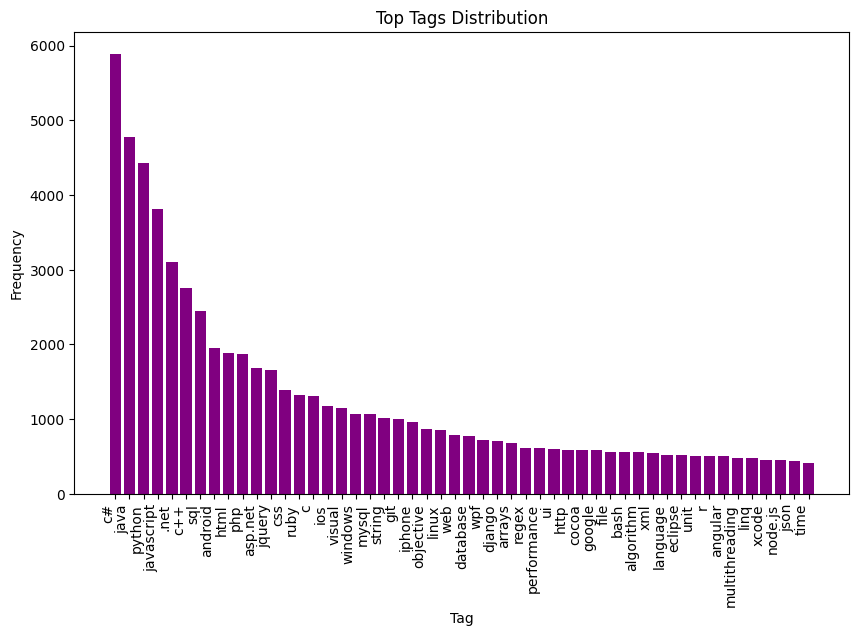

In [ ]:
# Assuming data['Filtered_Tags'] contains the filtered tags
all_filtered_tags = [tag for tags_list in data['Filtered_Tags'] for tag in tags_list]

# Count occurrences of each filtered tag
tag_counts = pd.Series(all_filtered_tags).value_counts().reset_index()
tag_counts.columns = ['Tag', 'Count']

# Select the top 20 tags
top_tags = tag_counts.head(50)

# Plot a bar plot of the top  tag distribution
plt.figure(figsize=(10, 6))
plt.bar(top_tags['Tag'], top_tags['Count'], color='purple')
plt.xlabel('Tag')
plt.ylabel('Frequency')
plt.title('Top Tags Distribution')
plt.xticks(rotation=90, ha='right')
plt.show()

In [ ]:
len(all_filtered_tags)

94522

In [ ]:
# Create a copy of the original DataFrame
filtered_data = data[['Body', 'Title', 'Filtered_Tags']].copy()
# Rename 'Filtered_Tags' to 'Tags'
filtered_data = filtered_data.rename(columns={'Filtered_Tags': 'Tags'})
# Assuming filtered_data is the DataFrame you want to save
filtered_data.to_csv('/content/drive/MyDrive/Datasets/filtered_data.csv', index=False)

# Display the resulting DataFrame
filtered_data

,Body,Title,Tags
0,<p>I have a <code>DataTable</code> with a <cod...,"How do I get a distinct, ordered list of names...","[.net, linq, c#]"
1,<p>Where can I find a list of all of the MIME ...,"Microsoft Office 2007 file type, Mime types an...",[file]
2,<p>How do you page through a collection in LIN...,Paging a collection with LINQ,"[.net, linq]"
3,<p>The version of <strong>Subclipse (1.2.4)</s...,Getting Subclipse in Aptana to work with the n...,"[eclipse, svn]"
4,<p>I've written a database generation script i...,SQLStatement.execute() - multiple queries in o...,[apache]
...,...,...,...
49111,<p>Is there any practical difference between <...,"Difference between const std::array<T,N> and s...",[c++]
49112,<p>I'm reading Avalonia source code and I came...,What does assignment to a bracketed expression...,[c#]
49113,<pre><code>#include &lt;iostream&gt;\n\nint&am...,What should the result be when assigning a var...,[c++]
49114,<p>Suddenly android studio showed this message...,File pattern '*.apk' (from 'bundled' plugin) w...,[android]


# 2. Tokenization of text

In [ ]:
# Instantiate stemmer that will be used along the processing pipeline
stemmer = PorterStemmer()

# Initialize MWETokenizer
tokenizer = MWETokenizer()

# Add the multi-word expression to the tokenizer
mwe_tuple = tuple(list_tags)
tokenizer.add_mwe(mwe_tuple)

# Customize stopwords list
custom_stopwords = set(stopwords.words('english')) - set(list_tags)
stop_w = list(custom_stopwords)

def replace_contractions(text):
    # Replace contractions with their expanded forms
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can't", "cannot", text)
    text = re.sub(r"n't", " not", text)
    text = re.sub(r"'re", " are", text)
    text = re.sub(r"'s", " is", text)
    text = re.sub(r"'d", " would", text)
    text = re.sub(r"'ll", " will", text)
    text = re.sub(r"'t", " not", text)
    text = re.sub(r"'ve", " have", text)
    text = re.sub(r"'m", " am", text)

    return text

def tokenizer_fct(sentence):
    # Remove HTML tags using BeautifulSoup
    text_without_tags = BeautifulSoup(replace_contractions(sentence), 'html.parser').get_text()

    # Add spaces before and after specific characters
    text_with_spaces = re.sub(r'([,\?])', r' \1 ', text_without_tags)

    # Replace multiple spaces with a single space
    text_with_spaces = re.sub(r'\s+', ' ', text_with_spaces)

    # Remove numbers and special characters except ,\.?+#
    text_with_spaces = re.sub(r'[^a-zA-Z,?#+]', ' ', text_with_spaces)

    # Tokenize multi-word expressions using MWETokenizer
    word_tokens = tokenizer.tokenize(text_with_spaces.split())

    return word_tokens

# lower case and alpha
def lower_start_fct(list_words):
    lw = [w.lower() for w in list_words]
    return lw

def lemma_fct(list_words):
    lemmatizer = WordNetLemmatizer()
    lem_w = [stemmer.stem(lemmatizer.lemmatize(w)) for w in list_words]
    return lem_w

# Function for text preparation for Bag of Words with lemmatization (CountVectorizer and Tf-idf, Word2Vec)
def transform_bow_lem_fct(desc_text):
    word_tokens = tokenizer_fct(desc_text)
    sw = [w for w in word_tokens if not w in stop_w and len(w) > 1]
    lw = lower_start_fct(sw)
    lem_w = lemma_fct(lw)
    transf_desc_text = ' '.join(lem_w)
    return transf_desc_text

# Function for text preparation for Deep Learning (USE and BERT)
def transform_dl_fct(desc_text) :
    word_tokens = tokenizer_fct(desc_text)
    lw = lower_start_fct(word_tokens)
    # lem_w = lemma_fct(lw)
    transf_desc_text = ' '.join(lw)
    return transf_desc_text

In [ ]:
df = filtered_data.copy()
# Concatenate 'title' and 'body' columns with a space in between
df['Text'] = df['Title'] + df['Body']
df = df[['Text', 'Tags']]
df

,Text,Tags
0,"How do I get a distinct, ordered list of names...","[.net, linq, c#]"
1,"Microsoft Office 2007 file type, Mime types an...",[file]
2,Paging a collection with LINQ<p>How do you pag...,"[.net, linq]"
3,Getting Subclipse in Aptana to work with the n...,"[eclipse, svn]"
4,SQLStatement.execute() - multiple queries in o...,[apache]
...,...,...
49111,"Difference between const std::array<T,N> and s...",[c++]
49112,What does assignment to a bracketed expression...,[c#]
49113,What should the result be when assigning a var...,[c++]
49114,File pattern '*.apk' (from 'bundled' plugin) w...,[android]


In [ ]:
# Save the DataFrame to a CSV file
df.to_csv('/content/drive/MyDrive/Datasets/data_50kposts.csv', index=False)

In [ ]:
# Apply text preprocessing functions
#df['sentence_bow_lem'] = df['Text'].apply(lambda x : transform_bow_lem_fct(x))

In [ ]:
df['sentence_dl'] = df['Text'].apply(lambda x : transform_dl_fct(x))

In [ ]:
df.head()

,Text,Tags,sentence_dl
0,"How do I get a distinct, ordered list of names...","[.net, linq, c#]","how do i get a distinct , ordered list of name..."
1,"Microsoft Office 2007 file type, Mime types an...",[file],"microsoft office file type , mime types and id..."
2,Paging a collection with LINQ<p>How do you pag...,"[.net, linq]",paging a collection with linqhow do you page t...
3,Getting Subclipse in Aptana to work with the n...,"[eclipse, svn]",getting subclipse in aptana to work with the n...
4,SQLStatement.execute() - multiple queries in o...,[apache],sqlstatement execute multiple queries in one s...


# 3. Embedding and Model Training

# 3.1 CountVectorizer & TfidfVectorizer Embedding and XGBoost

In [ ]:
# Define X and y
X = df['sentence_bow_lem']
y = df['Tags']

# Convert the tags into binary labels
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Embedding CountVectorizer / TfidfVectorizer
cvect = CountVectorizer(stop_words='english', max_df=0.95, min_df=1)
ctf = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=1)

# Train separate models for each pipeline
X_train_cv = cvect.fit_transform(X_train)
X_train_tfidf = ctf.fit_transform(X_train)

clf_cv = XGBClassifier(n_estimators=50, random_state=42)
clf_tfidf = XGBClassifier(n_estimators=50, random_state=42)

clf_cv.fit(X_train_cv, y_train)
clf_tfidf.fit(X_train_tfidf, y_train)

# Evaluate the models
X_test_cv = cvect.transform(X_test)
y_pred_cv = clf_cv.predict(X_test_cv)
y_pred_cv_decoded = mlb.inverse_transform(y_pred_cv)

X_test_tfidf = ctf.transform(X_test)
y_pred_tfidf = clf_tfidf.predict(X_test_tfidf)
y_pred_tfidf_decoded = mlb.inverse_transform(y_pred_tfidf)

print('CountVectorizer model:')
print('Accuracy:', accuracy_score(y_test, y_pred_cv))
print('Precision:', precision_score(y_test, y_pred_cv, average='micro'))
print('Recall:', recall_score(y_test, y_pred_cv, average='micro'))
print('F1 score:', f1_score(y_test, y_pred_cv, average='micro'))

print('TfidfVectorizer model:')
print('Accuracy:', accuracy_score(y_test, y_pred_tfidf))
print('Precision:', precision_score(y_test, y_pred_tfidf, average='micro'))
print('Recall:', recall_score(y_test, y_pred_tfidf, average='micro'))
print('F1 score:', f1_score(y_test, y_pred_tfidf, average='micro'))

CountVectorizer model:
Accuracy: 0.4192119904621324
Precision: 0.8053626749278924
Recall: 0.5773030094187916
F1 score: 0.6725245316681535
TfidfVectorizer model:
Accuracy: 0.42329964800726694
Precision: 0.8046875
Recall: 0.5836587793858642
F1 score: 0.6765789356886069


**CountVectorizer Model:**


1.   Accuracy (0.419): Low overall correctness in label predictions.
2.   Precision (0.805): Identifies relevant labels well, but with some false positives.
3.   Recall (0.577): Misses a significant number of actual positive labels.
4.   F1 Score (0.673): Moderate overall performance.


**TfidfVectorizer Model:**


1.   Accuracy (0.423): Similar to CountVectorizer, indicating potential for improvement.
2.   Precision (0.805): Identifies relevant labels well, but with some false positives.
3.   Recall (0.584): Slightly better at capturing actual positive labels.
4.   F1 Score (0.677): Moderate overall performance, with a slight improvement.

**Both models have high precision but struggle with recall, suggesting room for enhancement in capturing all relevant labels. Further tuning or advanced techniques may be considered for improvement.**

In [ ]:
# Tagging the training and testing documents
tagged_data_train = [TaggedDocument(words=doc.split(), tags=[str(i)]) for i, doc in enumerate(X_train)]
tagged_data_test = [TaggedDocument(words=doc.split(), tags=[str(i)]) for i, doc in enumerate(X_test)]

# Instantiate and train the Doc2Vec model
doc2vec_model = Doc2Vec(vector_size=100,  # Set the dimensionality of the feature vectors
                       window=10,          # Maximum distance between the current and predicted word within a sentence
                       min_count=1,       # Ignores all words with total frequency lower than this
                       workers=4,         # Number of CPU cores to use for training the model
                       epochs=20)         # Number of iterations (epochs) over the corpus

# Build the vocabulary
doc2vec_model.build_vocab(tagged_data_train)

# Train the Doc2Vec model on the GPU
with tf.device('/GPU:0'):
    doc2vec_model.train(tagged_data_train, total_examples=doc2vec_model.corpus_count, epochs=doc2vec_model.epochs, )

    # Save the trained model if needed
doc2vec_model.save("/content/drive/MyDrive/Datasets/doc2vec_model")

# Transform documents to Doc2Vec vectors for both training and testing sets
X_train_doc2vec = [doc2vec_model.infer_vector(doc.words) for doc in tagged_data_train]
X_test_doc2vec = [doc2vec_model.infer_vector(doc.words) for doc in tagged_data_test]

# Train XGBClassifier on Doc2Vec embeddings
clf_doc2vec = XGBClassifier(n_estimators=100, random_state=42)
clf_doc2vec.fit(X_train_doc2vec, y_train)

# Evaluate the model
y_pred_doc2vec = clf_doc2vec.predict(X_test_doc2vec)
y_pred_doc2vec_decoded = mlb.inverse_transform(y_pred_doc2vec)

print('Doc2Vec model:')
print('Accuracy:', accuracy_score(y_test, y_pred_doc2vec))
print('Precision:', precision_score(y_test, y_pred_doc2vec, average='micro'))
print('Recall:', recall_score(y_test, y_pred_doc2vec, average='micro'))
print('F1 score:', f1_score(y_test, y_pred_doc2vec, average='micro'))

Doc2Vec model:
Accuracy: 0.17270353128193483
Precision: 0.7164995442114859
Recall: 0.24075350333103607
F1 score: 0.3604058004241417



**Doc2Vec Model:**



1.   Accuracy (0.173): Low overall correctness in label predictions.
2.   Precision (0.716): Identifies relevant labels reasonably well, but with a moderate number of false positives.
3.   Recall (0.241): Captures a relatively small proportion of actual positive labels, indicating significant missed positives.
4.   F1 Score (0.360): Low overall performance, with a balance between precision and recall.

**The Doc2Vec model shows challenges in accurately predicting labels, particularly in terms of recall. The precision suggests that when it predicts a label, it is often correct, but the low recall indicates significant room for improvement in capturing all relevant labels. Further refinement or alternative approaches may be explored for enhancement.**

#3.2 Bert & Universal Sentence Embedding

## 3.2.1 Universal Sentence Embedding

In [ ]:
def feature_USE_fct(sentences, b_size):
    batch_size = b_size
    embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

    # Initialize features before the loop
    features = None

    for step in range(len(sentences)//batch_size):
        idx = step * batch_size
        feat = embed(sentences[idx:idx + batch_size])

        if step == 0:
            features = feat
        else:
            features = np.concatenate((features, feat))

    return features

In [ ]:
# Define X and y
Dx = df['sentence_dl'].copy()
y = df['Tags']

# Set batch size for USE feature extraction
batch_size = 32

# Ensure that X is divisible evenly by the batch size
num_samples = len(Dx)
remainder = num_samples % batch_size

if remainder != 0:
    # Adjust the size of the last batch or choose a different batch size
    adjusted_size = (num_samples // batch_size) * batch_size
    Dx = Dx.iloc[:adjusted_size]
    y = y[:adjusted_size]

# Convert the tags into binary labels
mlb = MultiLabelBinarizer()
y_binary = mlb.fit_transform(y)

# Save the MultiLabelBinarizer
mlb_filename = '/content/drive/MyDrive/Datasets/mlb_model.sav'
pickle.dump(mlb, open(mlb_filename, 'wb'))

# Extract USE features
X = feature_USE_fct(Dx, batch_size)

In [ ]:
# Create an instance of MultilabelStratifiedKFold
mskf = MultilabelStratifiedKFold(n_splits=20, random_state=42, shuffle=True)

# Initialize metrics
accuracy_list = []
precision_list = []
recall_list = []
f1_list = []

# Initialize a list to store base models
base_models = []

# Use it in cross-validation
for train_val_index, test_index in mskf.split(X, y_binary):
    X_train_val, X_test = X[train_val_index], X[test_index]
    y_train_val, y_test = y_binary[train_val_index], y_binary[test_index]

    # Further split the train set into train and validation
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

    # Define the base model
    base_model = XGBClassifier(n_estimators=10, random_state=42)

    print('---------------------------------------')
    print('Base Model Fold:', len(accuracy_list))
    # Train the base model
    base_model.fit(X_train, y_train)

    # Append the trained base model to the list
    base_models.append(base_model)

    # Evaluate the base model
    y_pred = base_model.predict(X_test)

    # Metrics
    accuracy_list.append(accuracy_score(y_test, y_pred))
    precision_list.append(precision_score(y_test, y_pred, average='micro'))
    recall_list.append(recall_score(y_test, y_pred, average='micro'))
    f1_list.append(f1_score(y_test, y_pred, average='micro'))

    print('Accuracy:', accuracy_score(y_test, y_pred))
    print('Precision:', precision_score(y_test, y_pred, average='micro'))
    print('Recall:', recall_score(y_test, y_pred, average='micro'))
    print('F1 score:', f1_score(y_test, y_pred, average='micro'))
    print('---------------------------------------')

folder_path = '/content/drive/MyDrive/Datasets/'
for i, model in enumerate(base_models):
    model_filename = f'{folder_path}model_fold_{i}.json'
    model.save_model(model_filename)
    print(f'Model {i} saved as: {model_filename}')

---------------------------------------
Base Model Fold: 0
Accuracy: 0.22932790224032587
Precision: 0.7680533751962323
Recall: 0.41444303261329946
F1 score: 0.5383768913342504
---------------------------------------
---------------------------------------
Base Model Fold: 1
Accuracy: 0.23993493289955267
Precision: 0.7846871356393316
Recall: 0.42857142857142855
F1 score: 0.5543657331136739
---------------------------------------
---------------------------------------
Base Model Fold: 2
Accuracy: 0.23805634953042057
Precision: 0.7910505836575875
Recall: 0.4301735082522217
F1 score: 0.5572916666666666
---------------------------------------
---------------------------------------
Base Model Fold: 3
Accuracy: 0.22985197368421054
Precision: 0.7851880573865839
Recall: 0.428480744815912
F1 score: 0.5544147843942505
---------------------------------------
---------------------------------------
Base Model Fold: 4
Accuracy: 0.22509225092250923
Precision: 0.7821341956345998
Recall: 0.4090044388

In [ ]:
# Split the entire data into training, validation, and testing sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y_binary, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

# Define the meta model
meta_model = XGBClassifier(n_estimators=20, random_state=42)

# Use the trained base models to make predictions on the validation set
base_preds = []
for base_model in base_models:
    base_pred = base_model.predict(X_val)
    base_preds.append(base_pred)

# Stack the base model predictions and use them to train the meta model
stacked_X = np.column_stack(base_preds)
meta_model.fit(stacked_X, y_val)

# Use the trained base models to make predictions on the test set
base_preds_test = []
for base_model in base_models:
    base_pred_test = base_model.predict(X_test)
    base_preds_test.append(base_pred_test)

# Stack the base model predictions and use them to make predictions with the meta model
stacked_X_test = np.column_stack(base_preds_test)
y_pred_prob_meta = meta_model.predict(stacked_X_test)

# Set a threshold (for example, 0.5)
threshold = 0.5
y_pred_meta = (y_pred_prob_meta > threshold).astype(int)

# Evaluate the stacked model
accuracy_stacked = accuracy_score(y_test, y_pred_meta)
precision_stacked = precision_score(y_test, y_pred_meta, average='micro')
recall_stacked = recall_score(y_test, y_pred_meta, average='micro')
f1_stacked = f1_score(y_test, y_pred_meta, average='micro')

print('Stacked Model Metrics:')
print('Treshold:', threshold)
print('Accuracy:', accuracy_stacked.round(3))
print('Precision:', precision_stacked.round(3))
print('Recall:', recall_stacked.round(3))
print('F1 score:', f1_stacked.round(3))

model_filename = f'{folder_path}meta_use.json'
model.save_model(model_filename)
print(f'Meta model saved as: {model_filename}')

**Universal Sentence Encoder model:**


1.   Accuracy (0.515): Moderate overall correctness in label predictions.
2.   Precision (0.898): High precision, indicating a low false-positive rate.
3.   Recall (0.733): Captures a higher proportion of actual positive labels compared to the Universal Sentence Encoder base models.
4.   F1 Score (0.807): Improved overall performance, with a better balance between precision and recall.

*   Base models exhibit relatively low performance. Suggests potential limitations with the chosen XGBoost classifier or a need for further feature engineering or hyperparameter tuning.
*   Stacked model showcases significantly improved performance. The stacking approach effectively combines base models' predictions, demonstrating its effectiveness.

*   Precision and recall scores for both base models and the stacked model are high, indicating accurate identification of relevant tags.
*   Notably, the recall scores for base models are relatively low compared to precision, suggesting potential missed relevant tags. The stacked model's higher recall implies successful enhancement through the stacking approach.

**Overall, the results suggest that the stacking approach is effective at improving performance on this dataset, and that further experimentation with different models or feature engineering techniques may be necessary to improve the performance of the base models.**

In [ ]:
tags_meta = mlb.inverse_transform(y_pred_meta[0:5])
print('Tags from meta model:', tags_meta)
print('Actual tags:', mlb.inverse_transform(y_test[0:5]))

Tags from meta model: [('datetime', 'sql'), ('java', 'string'), ('c#',), ('macos',), ('bash', 'shell')]
Actual tags: [('datetime', 'mysql'), ('java', 'string'), ('c#',), ('macos',), ('bash', 'shell')]


In [ ]:
from xgboost import XGBClassifier

# Function to load all models from a folder
def load_base_models(folder_path='/content/drive/MyDrive/Datasets/'):
    loaded_models = []

    for i in range(7):
        model_filename = f'{folder_path}model_fold_{i}.json'

        # Create an instance of XGBClassifier
        loaded_model = XGBClassifier()

        # Load the saved model
        loaded_model.load_model(model_filename)

        # Append the loaded model to the list
        loaded_models.append(loaded_model)

        print(f'Model {i} loaded from: {model_filename}')

    return loaded_models

# Example usage
loaded_models = load_base_models()


Model 0 loaded from: /content/drive/MyDrive/Datasets/model_fold_0.json
Model 1 loaded from: /content/drive/MyDrive/Datasets/model_fold_1.json
Model 2 loaded from: /content/drive/MyDrive/Datasets/model_fold_2.json
Model 3 loaded from: /content/drive/MyDrive/Datasets/model_fold_3.json
Model 4 loaded from: /content/drive/MyDrive/Datasets/model_fold_4.json
Model 5 loaded from: /content/drive/MyDrive/Datasets/model_fold_5.json
Model 6 loaded from: /content/drive/MyDrive/Datasets/model_fold_6.json


In [ ]:
def load_meta_model(model_filename=model_filename):
    # Create an instance of XGBClassifier
    loaded_meta_model = XGBClassifier()

    # Load the saved meta model
    loaded_meta_model.load_model(model_filename)

    print(f'Meta Model loaded from: {model_filename}')

    return loaded_meta_model

# Load the meta model
loaded_meta_model = load_meta_model()

Meta Model loaded from: /content/drive/MyDrive/Datasets/meta_use.json


In [ ]:
# Assume you have a new sentence
new_sentence = 'c++ is a programming language c java python '

# Preprocess & embed the sentence
preprocessed_sentence = transform_dl_fct(new_sentence)
embedded_sentence = embed([preprocessed_sentence])

# Use the base models to get predictions
base_preds_new_sentence = []
for base_model in loaded_models:
    base_pred_new_sentence = base_model.predict(embedded_sentence)
    print(mlb.inverse_transform(base_pred_new_sentence))
    base_preds_new_sentence.append(base_pred_new_sentence)

[('c++', 'java', 'python')]
[('java', 'python')]
[('c++', 'java', 'python')]
[('c++', 'java', 'python')]
[('c#', 'c++', 'java', 'python')]
[('c', 'c++', 'java', 'python')]
[('java', 'python')]


In [ ]:
# Use the base models to get predictions
all_predicted_tags = set()

for base_model in loaded_models:
    base_pred_new_sentence = base_model.predict(embedded_sentence)
    predicted_labels = mlb.inverse_transform(base_pred_new_sentence)[0]

    # Add the predicted labels to the set
    all_predicted_tags.update(predicted_labels)

# Convert the set of unique tags to a list
final_prediction_labels = list(all_predicted_tags)

print("Final Prediction:")
print(final_prediction_labels)

## 3.2.2 BERT - DistilBERT

In [ ]:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
# Define X and y
X = df['sentence_dl']
y = df['Tags']

# Convert the tags into binary labels
mlb = MultiLabelBinarizer()
y_binary = mlb.fit_transform(y)

# Create an instance of MultilabelStratifiedKFold
mskf = MultilabelStratifiedKFold(n_splits=4, random_state=42, shuffle=True)

# Initialize metrics
accuracy_list = []
precision_list = []
recall_list = []
f1_list = []

# Initialize a list to store base models
base_models = []

# Use it in cross-validation
for train_val_index, test_index in mskf.split(X, y_binary):
    X_train_val, X_test = X.iloc[train_val_index], X.iloc[test_index]
    y_train_val, y_test = y_binary[train_val_index], y_binary[test_index]

    # Further split the train set into train and validation
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

    # Define the tokenizer and model INSIDE the loop
    tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
    model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=y_binary.shape[1])

    # Tokenize the input data
    X_train_encodings = tokenizer(list(X_train), truncation=True, padding=True)
    X_val_encodings = tokenizer(list(X_val), truncation=True, padding=True)
    X_test_encodings = tokenizer(list(X_test), truncation=True, padding=True)

    # Convert the data to TensorFlow datasets
    train_dataset = tf.data.Dataset.from_tensor_slices((dict(X_train_encodings), y_train))
    val_dataset = tf.data.Dataset.from_tensor_slices((dict(X_val_encodings), y_val))
    test_dataset = tf.data.Dataset.from_tensor_slices((dict(X_test_encodings), y_test))

    # Define the training parameters
    optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    metric = tf.keras.metrics.BinaryAccuracy('accuracy')

    # Compile the model
    model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

    print('---------------------------------------')
    print('Model Fold:', len(accuracy_list))

    # Train the model
    model.fit(
        train_dataset.shuffle(1000).batch(32),
        epochs=3,
        batch_size=32,
        validation_data=val_dataset.shuffle(1000).batch(32)
    )

    # Evaluate the model
    y_pred_logits = model.predict(test_dataset.batch(32))

    # Extract logits from TFSequenceClassifierOutput
    logits = y_pred_logits.logits

    # Apply sigmoid activation to logits
    y_pred_prob = tf.nn.sigmoid(logits)
    y_pred_np = np.round(y_pred_prob)

    # Convert y_test to a numpy array
    y_test_np = np.array(y_test)

    # Metrics
    accuracy_list.append(accuracy_score(y_test_np, y_pred_np))
    precision_list.append(precision_score(y_test_np, y_pred_np, average='micro'))
    recall_list.append(recall_score(y_test_np, y_pred_np, average='micro'))
    f1_list.append(f1_score(y_test_np, y_pred_np, average='micro'))


    print('Accuracy:', accuracy_score(y_test_np, y_pred_np))
    print('Precision:', precision_score(y_test_np, y_pred_np, average='micro'))
    print('Recall:', recall_score(y_test_np, y_pred_np, average='micro'))
    print('F1 score:', f1_score(y_test_np, y_pred_np, average='micro'))
    print('---------------------------------------')

    # Append the trained base model to the list
    base_models.append(model)

# Calculate average metrics
avg_accuracy = sum(accuracy_list) / len(accuracy_list)
avg_precision = sum(precision_list) / len(precision_list)
avg_recall = sum(recall_list) / len(recall_list)
avg_f1 = sum(f1_list) / len(f1_list)

print('---------------------------------------')
print('Average Metrics:')
print('Accuracy:', avg_accuracy)
print('Precision:', avg_precision)
print('Recall:', avg_recall)
print('F1 score:', avg_f1)
print('---------------------------------------')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

---------------------------------------
Model Fold: 0
Epoch 1/3
922/922 [==============================] - 420s 436ms/step - loss: 0.0713 - accuracy: 0.9905 - val_loss: 0.0355 - val_accuracy: 0.9915
Epoch 2/3
922/922 [==============================] - 399s 433ms/step - loss: 0.0284 - accuracy: 0.9927 - val_loss: 0.0234 - val_accuracy: 0.9935
Epoch 3/3
383/383 [==============================] - 51s 129ms/step
Accuracy: 0.30840205764677064
Precision: 0.8512017479970867
Recall: 0.494248498688996
F1 score: 0.6253745719178082
---------------------------------------


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

---------------------------------------
Model Fold: 1
Epoch 1/3
920/920 [==============================] - 419s 436ms/step - loss: 0.0696 - accuracy: 0.9905 - val_loss: 0.0357 - val_accuracy: 0.9917
Epoch 2/3
920/920 [==============================] - 398s 433ms/step - loss: 0.0289 - accuracy: 0.9927 - val_loss: 0.0238 - val_accuracy: 0.9934
Epoch 3/3
385/385 [==============================] - 51s 129ms/step
Accuracy: 0.3135758363104904
Precision: 0.8552661043517206
Recall: 0.48485104942450913
F1 score: 0.6188662939857948
---------------------------------------


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

---------------------------------------
Model Fold: 2
Epoch 1/3
922/922 [==============================] - 421s 435ms/step - loss: 0.0692 - accuracy: 0.9906 - val_loss: 0.0340 - val_accuracy: 0.9918
Epoch 2/3
922/922 [==============================] - 399s 433ms/step - loss: 0.0281 - accuracy: 0.9928 - val_loss: 0.0237 - val_accuracy: 0.9934
Epoch 3/3
383/383 [==============================] - 51s 129ms/step
Accuracy: 0.30916809535472284
Precision: 0.8278427923966718
Recall: 0.5178133197935179
F1 score: 0.63711377775464
---------------------------------------


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

---------------------------------------
Model Fold: 3
Epoch 1/3
921/921 [==============================] - 421s 436ms/step - loss: 0.0698 - accuracy: 0.9905 - val_loss: 0.0349 - val_accuracy: 0.9917
Epoch 2/3
921/921 [==============================] - 399s 433ms/step - loss: 0.0284 - accuracy: 0.9927 - val_loss: 0.0239 - val_accuracy: 0.9933
Epoch 3/3
385/385 [==============================] - 51s 129ms/step
Accuracy: 0.3159135240572172
Precision: 0.8177912894058555
Recall: 0.5240999576450657
F1 score: 0.6388064324617331
---------------------------------------
---------------------------------------
Average Metrics:
Accuracy: 0.31176487834230027
Precision: 0.8380254835378336
Recall: 0.5052532063880222
F1 score: 0.630040269029994
---------------------------------------


In [ ]:
# Save the trained base models
for i, base_model in enumerate(base_models):
    filename = '/content/drive/MyDrive/Datasets/Bert_' + str(i) + '.sav'
    pickle.dump(base_model, open(filename, 'wb'))

In [ ]:
# Define X and y
X = df['sentence_dl']
y = df['Tags']

# Convert the tags into binary labels
mlb = MultiLabelBinarizer()
y_binary = mlb.fit_transform(y)

# Split the entire data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.5, random_state=42)

In [ ]:
# Initialize a list to store base model predictions
base_preds_train = []

# Use the trained base models to make predictions on the validation set
for base_model in base_models:
    # Tokenize the input data
    X_val_encodings = tokenizer(list(X_train), truncation=True, padding=True)

    # Convert the data to TensorFlow datasets
    val_dataset = tf.data.Dataset.from_tensor_slices((dict(X_val_encodings), y_train))

    # Predictions from the last layer's output (logits)
    y_pred_logits = base_model.predict(val_dataset.batch(32))

    # Extract logits from TFSequenceClassifierOutput
    logits = y_pred_logits.logits

    # Apply sigmoid activation to logits
    y_pred_prob = tf.nn.sigmoid(logits)
    y_pred_np = np.round(y_pred_prob)

    # Convert y_test to a numpy array
    y_test_np = np.array(y_pred_np)

    # Append the predictions to the list
    base_preds_train.append(y_pred_np)

# Stack the base model predictions and use them to train the meta model
stacked_X_train = np.column_stack(base_preds_train)

# Define the meta model
meta_model = XGBClassifier(n_estimators=50, random_state=42)

# Train the meta model
meta_model.fit(stacked_X_train, y_train)

# Initialize a list to store base model predictions on the test set
base_preds_test = []

# Use the trained base models to make predictions on the test set
for base_model in base_models:
    # Tokenize the input data
    X_test_encodings = tokenizer(list(X_test), truncation=True, padding=True)

    # Convert the data to TensorFlow datasets
    test_dataset = tf.data.Dataset.from_tensor_slices((dict(X_test_encodings), y_test))

    # Predictions from the last layer's output (logits)
    y_pred_logits_test = base_model.predict(test_dataset.batch(32))

    # Extract logits from TFSequenceClassifierOutput
    logits = y_pred_logits_test.logits

    # Apply sigmoid activation to logits
    y_pred_prob_test = tf.nn.sigmoid(logits)
    y_pred_np_test = np.round(y_pred_prob_test)

    # Convert y_test to a numpy array
    y_pred_np_test = np.array(y_pred_np_test)

    # Append the predictions to the list
    base_preds_test.append(y_pred_np_test)

768/768 [==============================] - 99s 129ms/step


In [ ]:
# Stack the base model predictions on the test set
stacked_X_test = np.column_stack(base_preds_test)

# Use predict_proba to get probabilities
y_pred_prob_meta = meta_model.predict_proba(stacked_X_test)

# Set a threshold (for example, 0.5)
threshold = 0.5
y_pred_meta = (y_pred_prob_meta > threshold).astype(int)

# Evaluate the stacked model
accuracy_stacked = accuracy_score(y_test, y_pred_meta)
precision_stacked = precision_score(y_test, y_pred_meta, average='micro')
recall_stacked = recall_score(y_test, y_pred_meta, average='micro')
f1_stacked = f1_score(y_test, y_pred_meta, average='micro')

print('Stacked Model Metrics:')
print('Treshold:', threshold)
print('Accuracy:', accuracy_stacked.round(3))
print('Precision:', precision_stacked.round(3))
print('Recall:', recall_stacked.round(3))
print('F1 score:', f1_stacked.round(3))

Stacked Model Metrics:
Treshold: 0.5
Accuracy: 0.368
Precision: 0.857
Recall: 0.585
F1 score: 0.695


The choice between prioritizing precision or recall depends on the specific goals and requirements of your application, and it often involves a trade-off. Let's discuss the implications of prioritizing each metric:



1.   ***Precision:***

*   **High Precision:** This means that when the model predicts a certain tag, it is
likely to be correct. Precision is important when you want to avoid suggesting irrelevant tags to users, ensuring that the predicted tags are highly accurate.
*   **Trade-off:** A high precision might result in missing some relevant tags because the model is conservative in making predictions.

2.   ***Recall:***


*   **High Recall:** This means that your model is good at capturing all relevant tags in the dataset. It ensures that you don't miss suggesting relevant tags to users.
*   **Trade-off:** A high recall might result in suggesting more tags, including some that are irrelevant. This could lead to a larger number of false positives.

***In the context of our task, where a user describes an IT issue and we need to suggest multiple tags, a balanced approach might be beneficial.***

***So we can use F1 score, which combines precision and recall, as a metric to optimize to find a balance between the two.***

In [ ]:
# Save the trained stacked model
filename = '/content/drive/MyDrive/Datasets/stacked_Bert_model.sav'
pickle.dump(meta_model, open(filename, 'wb'))

In [ ]:
# Sweep over a range of threshold values
threshold_values = np.arange(0.1, 1.0, 0.01)

# Initialize variables to store results
best_threshold = None
best_f1_score = 0.0

# Evaluate F1 score for each threshold
for threshold in threshold_values:
    y_pred_thresholded = (y_pred_prob_meta > threshold).astype(int)
    f1 = f1_score(y_test, y_pred_thresholded, average='micro')

    # Update best threshold if a higher F1 score is found
    if f1 > best_f1_score:
        best_f1_score = f1
        best_threshold = threshold

print('Best Threshold:', best_threshold.round(3))
print('Best F1 Score:', best_f1_score.round(3))

Best Threshold: 0.33
Best F1 Score: 0.704
